# Tube Twin: Passenger count forecasting/general tube analysis 

© Explore Data Science Academy

## Introduction 

<div align="center" style="width: 600px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="../Assets/LU_Baker-street.jpg" 
     alt="London Underground"
     style="float: center; padding-bottom=0.5em"
     width=100%/>
     <p><em>Figure 1. The London Tube</em></p> 
</div>

**Client**: Transport for London (TfL) 

Transport for London runs the London Underground (aka “The Tube”), which is a network of train stations that connects the city of London.

**Team**: 

This is Team 6. A combination of data scientists and data engineers that have been assigned the Tube Twin project and this is a notebook for executing various aspect of the project workflow. 

## Context

This project's objective is to create a digital twin of the london tube that can be used for passenger count and traffic analyses/forecasting.


## Import libraries
In the cell below we import the libraries required to complete this section of the predict.

In [2]:
import findspark
findspark.init()
findspark.find()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import * 

> ℹ️ **Objective** ℹ️
>
>Initialise a new **Spark Context** and **Session** for interfacing with Spark.

In [3]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc) 

## Parquet files
We will be making use of the Parquet files from the ingestion phase to continue with this section of the data cleaning. 

> ℹ️ **Objective** ℹ️ 
>
> Read the parquet files stored from the Data_Ingestion_Notebook into a Spark DataFrame. 

In [25]:
parquet_file_path = r'../Data/data_ingestion.parquet' 
df = spark.read.parquet(parquet_file_path, engine='auto') 

df.show(1) 

df.printSchema() 

print('Size of df (Rows, Columns):')
print((df.count(), len(df.columns))) 

+----+---+----+----------+--------------------+----------+---+---+------+-----+-------+----------+-------+-------+----+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+-

## Data Accuracy
Data accuracy is the degree to which data correctly describes a "real world" object or event.

It is important to do checks to determine the basic integrity of the dataset; do the values fall within expected ranges?

Most of the possible errors relating to data accuracy can occur at collection time. In our case, it is not possible to test the collection time accuracy, so we have to infer from ranges and summary statistics. Here you need to look closely at each field to see if its values make sense, with no strange surprises.

In assessing accuracy, it is important to look into precision as well. Do you need seven decimals, or will one or two suffice?

- **Measured by**: The degree to which the data mirrors the characteristics of the real-world object or objects it represents;
- **Units**: The percentage of data entries that pass the data accuracy rules;
- **Related to**: Validity, Uniqueness, Consistency.

> ℹ️ **Objective** ℹ️
>
> To start with, since the project is only about London Underground, we'll make sure that our dataframe only include data for London Underground (LU). To do that we'll create a LU dataframe and filter our any irrelevant data we don't need. 

In [26]:
# Filtering out all entries that are not LU nor Entry/Exit data from the dataframe. 
lu_df = df[df['Mode']=='LU'].orderBy('year') 
lu_df = lu_df[lu_df['coverage']=='Station entry / exit'] 

print('Size of lu_df (Rows, Columns):')
print((lu_df.count(), len(lu_df.columns))) 

Size of lu_df (Rows, Columns):
(10050, 111)


> ℹ️ **Objective** ℹ️
>
> We'll generate summary statistics to explore the data for us to understand the ranges, means, extremums, and deviations found in the data set.

In [27]:
# Setting column display to show all columns and showing the summary of our data. 
pd.set_option("display.max.columns", None) 

lu_df.summary().toPandas() 

,summary,mode,nlc,asc,station,coverage,day,dir,total,early,am_peak,inter_peak,pm_peak,evening,late,0500-0515,0515-0530,0530-0545,0545-0600,0600-0615,0615-0630,0630-0645,0645-0700,0700-0715,0715-0730,0730-0745,0745-0800,0800-0815,0815-0830,0830-0845,0845-0900,0900-0915,0915-0930,0930-0945,0945-1000,1000-1015,1015-1030,1030-1045,1045-1100,1100-1115,1115-1130,1130-1145,1145-1200,1200-1215,1215-1230,1230-1245,1245-1300,1300-1315,1315-1330,1330-1345,1345-1400,1400-1415,1415-1430,1430-1445,1445-1500,1500-1515,1515-1530,1530-1545,1545-1600,1600-1615,1615-1630,1630-1645,1645-1700,1700-1715,1715-1730,1730-1745,1745-1800,1800-1815,1815-1830,1830-1845,1845-1900,1900-1915,1915-1930,1930-1945,1945-2000,2000-2015,2015-2030,2030-2045,2045-2100,2100-2115,2115-2130,2130-2145,2145-2200,2200-2215,2215-2230,2230-2245,2245-2300,2300-2315,2315-2330,2330-2345,2345-0000,0000-0015,0015-0030,0030-0045,0045-0100,0100-0115,0115-0130,0130-0145,0145-0200,0200-0215,0215-0230,0230-0245,0245-0300,0300-0315,0315-0330,0330-0345,0345-0400,0400-0415,0415-0430,0430-0445,0445-0500
0,count,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050,10050
1,mean,None,643.7062686567165,None,None,None,None,None,10473.005745825127,294.01534705950996,1859.003960247704,3469.2536743258006,2709.660335194175,1380.5456431401428,760.5267856538562,5.504606188364067,10.568999633492894,15.72757687373652,24.17365687735379,35.912128858403925,50.969760697800574,66.18684148835676,84.97177644182497,101.67159599133244,119.27767742474059,138.69061684787866,154.51831490861983,166.6704703111183,180.98369401725517,188.41298403867145,188.86754227976598,173.1532142140023,159.9126987473941,149.67324633208526,137.1719051736697,123.9629475390496,122.46611114126088,124.7319994685469,124.93790705075608,122.7601315635591,126.09654860631966,131.3021369744815,134.77995020093462,137.04261744892568,141.29140670393977,145.19433856520115,147.4348817513416,149.70904719478455,151.53444464101275,152.99155878262732,151.60669595230277,150.86086103128704,151.37757049841446,153.31216849311963,154.9711557903337,159.29360908618614,163.73502705389586,170.87586527325325,176.98469438007223,189.89480735307902,196.63725040680734,206.35228158515486,212.36759730239118,235.30780767377928,243.03347565447513,253.63846343527385,252.10618484875457,252.55326900847516,241.25200328103196,223.73085954372561,202.78633551004216,184.54446805261483,162.2775318613537,143.76614592796608,128.786791124249,119.21209489523919,109.78021737369286,100.92136152030298,93.80207701793357,89.88451775536164,85.75407726250923,81.9660489517354,79.8503118102497,82.72300775419569,85.52249891435774,84.5987463710053,79.90914986470446,75.94273295241209,68.82655664852825,60.343395708702246,50.905827989259095,40.31622786588411,31.653819711192774,22.629360539085088,15.526000075039653,10.493933797436048,7.785333770920537,6.465119683630579,5.315914160890959,4.005970149253732,3.5602985074626865,3.2582089552238807,2.985771144278607,2.9091542288557215,2.6602985074626866,2.4838805970149256,2.1627860696517414,2.095323383084577,1.7323383084577115,1.67817684661319,2.036953361524056
2,stddev,None,85.14643565373267,None,None,None,None,None,16977.231879251474,529.354402310909,4028.9921029234465,5774.964415436257,4816.040010398957,2442.303133928439,1586.6492780127314,13.760317875592484,23.094372469772303,30.081336216561393,45.25924020053331,67.35796768873038,94.93912190013691,122.054611

> ℹ️ **Objective** ℹ️
>
> Generate histograms for six different distributions found in the data to understand the distribution of values. 
>
> In this case, we'll use the time of the day (`early`, `am_peak`, `inter_peak`, `pm_peak`, `evening`, and `late`) categories. 

In [28]:
interval_pd = df.select('am_peak', 'inter_peak', 'pm_peak', 'evening', 'late', 'early').toPandas()

interval_pd.head(5) 

,am_peak,inter_peak,pm_peak,evening,late,early
0,1101.199951,1185.699951,824.200012,213.199997,89.400002,288.200012
1,520.166687,622.000000,920.000000,208.416672,46.250000,172.583328
2,472.692322,1063.923096,1126.461548,333.230774,99.000000,103.000000
3,667.846130,505.692322,408.538452,99.384613,30.846153,360.230774
4,424.666656,256.600006,124.133331,21.066668,5.600000,148.399994


array([[<AxesSubplot:title={'center':'am_peak'}>,
        <AxesSubplot:title={'center':'inter_peak'}>],
       [<AxesSubplot:title={'center':'pm_peak'}>,
        <AxesSubplot:title={'center':'evening'}>],
       [<AxesSubplot:title={'center':'late'}>,
        <AxesSubplot:title={'center':'early'}>]], dtype=object)

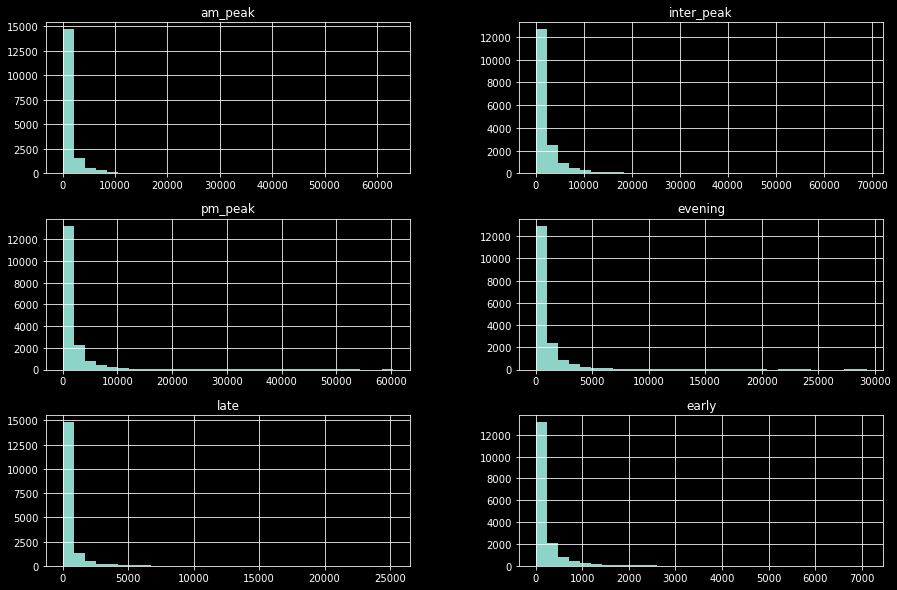

In [7]:
# Histogram View
interval_pd.hist(bins=30, figsize=(15, 10)) 

<AxesSubplot:>

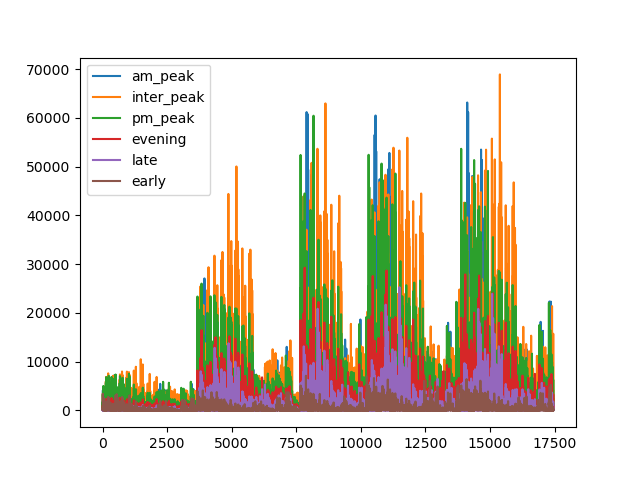

In [76]:
interval_pd.plot() 

> ℹ️ **Conclusion** ℹ️
>
> From the graphs, there seem to be no outliers or anomalies in the LU data accross the categories. 



## Checking for Data Completeness

Completeness is the proportion of stored data against the potential of “100% complete". This is the degree to which the required data is in the dataset. 

Does the dataset have missing values, or if it is time-series data, does it have time period gaps? Has a bias been introduced that may change your assumptions or affect your results?

- **Measured by**: A measure of the absence of blank (null) values or the presence of non-blank values;
- **Units**: Percentage;
- **Related to**: Validity and Accuracy. 

### Columns with missing values

> ℹ️ **Objective** ℹ️
>
> We will identify and count the number of missing values (nulls) in the dataset and return the results (if there's any). We will also include the percentage of such null values against the total entries in the specific column where it was found. 

In [29]:
missing_vals = {}  # Dictionary to keep track of the results 

for column in lu_df.columns:   # Loop through each column in lu_df 
    ncount = lu_df.where(lu_df[column].isNull()).count()  # Null count in column x
    tcount = lu_df.select(lu_df[column]).count()    # Total count of column x 
    if ncount > 0:  # If there are missing values at all... 
        print(f'There are {ncount} ({round(ncount/tcount*100, 2)}%) null values in {column} column')
        missing_vals[f'{column}'] = ncount # Recording results in missing_vals dictionary if there are missing value(s) 
    else: 
        pass # Otherwise, do nothing. 

if missing_vals == {}: # And if there are no missing values at all... 
    print(f'There are no missing values in the lu_df dataframe') # also, tell us. 

There are no missing values in the lu_df dataframe


> ℹ️ **Conclusion** ℹ️
>
> Gladly, our data passed the completeness check and has no missing values.  

## Data Transformation
Data transformation 
This will allow for further transformation to acheive date-time column which will be used for forecasting. 

- **Measured by**: ;
- **Units**: ;
- **Related to**: Validity, Uniqueness, Consistency. 

### Converting the TimeFrame columns into Row Index 

> ℹ️ **Objective** ℹ️
>
> We will convert the data from wide to long format by melting the time interval columns into rows. For this to happen, we will implement a `pd.melt()` method on the dataframe. 

In [60]:
'''Creating seperate dataframes for both Time of the Day categories and 15 minutes Time Intervals and converting them to pandas 
to be able to use the pd.melt() method''' 
time_of_day_df = lu_df.select(lu_df.columns[:15]).toPandas() # This won't be melted 
time_interval_df = lu_df.select(lu_df.columns[:8] + lu_df.columns[15:]).toPandas() # This will be melted 

id_cols = time_interval_df.columns[:8] # A list of the first 8 columns to use as identifier variables 
time_cols = time_interval_df.columns[8:] # A list of the time interval columns 

melted_time_interval_df = pd.melt(time_interval_df, id_vars = id_cols,  value_vars = time_cols, var_name = 'time_intervals', value_name = 'counts') # Melting

melted_time_interval_df.head() # Showing top rows of the new data structure 

,mode,nlc,asc,station,coverage,year,day,dir,time_intervals,counts
0,LU,500,ACTu,Acton Town,Station entry / exit,2017-01-01,MTF,IN,0500-0515,22.0
1,LU,502,ALDu,Aldgate,Station entry / exit,2017-01-01,MTF,IN,0500-0515,11.0
2,LU,503,ALEu,Aldgate East,Station entry / exit,2017-01-01,MTF,IN,0500-0515,6.0
3,LU,505,ALPu,Alperton,Station entry / exit,2017-01-01,MTF,IN,0500-0515,15.0
4,LU,506,AMEu,Amersham,Station entry / exit,2017-01-01,MTF,IN,0500-0515,1.0


In [39]:
time_of_day_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10050 entries, 0 to 10049
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mode        10050 non-null  object 
 1   nlc         10050 non-null  int32  
 2   asc         10050 non-null  object 
 3   station     10050 non-null  object 
 4   coverage    10050 non-null  object 
 5   year        10050 non-null  object 
 6   day         10050 non-null  object 
 7   dir         10050 non-null  object 
 8   total       10050 non-null  float32
 9   early       10050 non-null  float32
 10  am_peak     10050 non-null  float32
 11  inter_peak  10050 non-null  float32
 12  pm_peak     10050 non-null  float32
 13  evening     10050 non-null  float32
 14  late        10050 non-null  float32
dtypes: float32(7), int32(1), object(7)
memory usage: 863.8+ KB


In [40]:
melted_time_interval_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964800 entries, 0 to 964799
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   mode            964800 non-null  object 
 1   nlc             964800 non-null  int32  
 2   asc             964800 non-null  object 
 3   station         964800 non-null  object 
 4   coverage        964800 non-null  object 
 5   year            964800 non-null  object 
 6   day             964800 non-null  object 
 7   dir             964800 non-null  object 
 8   time_intervals  964800 non-null  object 
 9   counts          964800 non-null  float32
dtypes: float32(1), int32(1), object(8)
memory usage: 66.2+ MB


In [49]:
melted_time_interval_df.describe(include='all') 

,mode,nlc,asc,station,coverage,year,day,dir,time_intervals,counts
count,964800,964800.000000,964800,964800,964800,964800,964800,964800,964800,964800.000000
unique,1,NaN,495,267,1,5,5,2,96,NaN
top,LU,NaN,MYBu,Acton Town,Station entry / exit,2018-01-01,SAT,IN,0500-0515,NaN
freq,964800,NaN,3648,3648,964800,203520,253824,482400,10050,NaN
mean,NaN,643.706269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.061195
std,NaN,85.142244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,257.313446
min,NaN,500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,571.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000
50%,NaN,640.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.000000
75%,NaN,715.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101.000000


In [61]:
melted_time_interval_df['counts'].sum() # Keeping a record of our total counts figures. 

105253720.0

### Creating a DateTime column usable for Time Series analyses  

> ℹ️ **Objective** ℹ️
>
> We will now create a time series column using the year and the time-frame intervals. We will assume that entries are recorded towards the end of each record week and each record year, then assign a relative date to each `day` entry. 

In [62]:
# First, we'll extract date-time 'time' column from the 'time_intervals' column. 
import re 

time = []
for index, a in melted_time_interval_df['time_intervals'].items(): 
    b = re.match("(\d\d\d\d)-(\d\d\d\d)", a) 
    if b: 
        e = b.group(2) 
        e = e[:2]+':'+e[2:] 
        time.append(e) 

melted_time_interval_df['time'] = time # Now we have a 'time' date-time column to serve as the entry time. 

melted_time_interval_df.head(2) 

,mode,nlc,asc,station,coverage,year,day,dir,time_intervals,counts,time
0,LU,500,ACTu,Acton Town,Station entry / exit,2017-01-01,MTF,IN,0500-0515,22.0,05:15
1,LU,502,ALDu,Aldgate,Station entry / exit,2017-01-01,MTF,IN,0500-0515,11.0,05:15


In [63]:
''' Then we'll combine values in 'year', 'day' and 'time' columns to create a new 'date' date-time column that that will serve 
as the entry date column.''' 

year_list = [] 
day_list = [] 
time_list = [] 
year_day_time_list = [] 

for year in pd.to_datetime(melted_time_interval_df['year']).dt.year: 
    year_list.append(year) 

for day in melted_time_interval_df['day']: 
    if day == 'MTT': 
        day_list.append('-12-25') 
    elif day == 'MTF': 
        day_list.append('-12-26') 
    elif day == 'FRI': 
        day_list.append('-12-26') 
    elif day == 'SAT': 
        day_list.append('-12-27') 
    elif day == 'SUN': 
        day_list.append('-12-28') 

for time in melted_time_interval_df['time']: 
    time_list.append(time) 

for i in range(len(year_list)): 
    year_day_time_list.append(str(year_list[i])+day_list[i]+' '+time_list[i]) 

melted_time_interval_df['entry_date_time'] = year_day_time_list 

melted_time_interval_df.head(2) 

,mode,nlc,asc,station,coverage,year,day,dir,time_intervals,counts,time,entry_date_time
0,LU,500,ACTu,Acton Town,Station entry / exit,2017-01-01,MTF,IN,0500-0515,22.0,05:15,2017-12-26 05:15
1,LU,502,ALDu,Aldgate,Station entry / exit,2017-01-01,MTF,IN,0500-0515,11.0,05:15,2017-12-26 05:15


### Making some final transformations 

> ℹ️ **Objective** ℹ️
>
> We will rearrange the dataframe in such a way that the `entry_date_time` column comes first so we can use it as index when saving our data to a file. Also, we will convert the `year` column to show only the entry year. 

In [64]:
# Creating a new 'year' column from the current one that will hold just the entry year. 
melted_time_interval_df['year_of_entry'] = pd.to_datetime(melted_time_interval_df['year']).dt.year 

melted_time_interval_df = melted_time_interval_df.drop(['year'], axis=1) # deleting the old 'year' column 

# Rearranging the data structure for the 'entry_date_time' column to come first. 
final_time_interval_df = melted_time_interval_df[['entry_date_time', 'time', 
                            'mode',	'nlc',	'asc',	'station',	
                            'coverage',	'year_of_entry', 'day',	'dir',	
                            'time_intervals',	'counts']] 

final_time_interval_df.head() # Showing top rows of the final dataframe 

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
0,2017-12-26 05:15,05:15,LU,500,ACTu,Acton Town,Station entry / exit,2017,MTF,IN,0500-0515,22.0
1,2017-12-26 05:15,05:15,LU,502,ALDu,Aldgate,Station entry / exit,2017,MTF,IN,0500-0515,11.0
2,2017-12-26 05:15,05:15,LU,503,ALEu,Aldgate East,Station entry / exit,2017,MTF,IN,0500-0515,6.0
3,2017-12-26 05:15,05:15,LU,505,ALPu,Alperton,Station entry / exit,2017,MTF,IN,0500-0515,15.0
4,2017-12-26 05:15,05:15,LU,506,AMEu,Amersham,Station entry / exit,2017,MTF,IN,0500-0515,1.0


In [68]:
final_time_interval_df.tail(5) # Showing bottom rows of the final dataframe 

,entry_date_time,time,mode,nlc,asc,station,coverage,year_of_entry,day,dir,time_intervals,counts
964795,2021-12-28 05:00,05:00,LU,599,WDLu,Wood Lane,Station entry / exit,2021,SUN,OUT,0445-0500,0.625000
964796,2021-12-28 05:00,05:00,LU,769,WFDu,Woodford,Station entry / exit,2021,SUN,OUT,0445-0500,0.181818
964797,2021-12-28 05:00,05:00,LU,771,WSPu,Woodside Park,Station entry / exit,2021,SUN,OUT,0445-0500,0.000000
964798,2021-12-28 05:00,05:00,LU,831,NIEu,Nine Elms,Station entry / exit,2021,SUN,OUT,0445-0500,0.000000
964799,2021-12-28 05:00,05:00,LU,832,BPSu,Battersea Power Station,Station entry / exit,2021,SUN,OUT,0445-0500,0.111111


In [71]:
time_of_day_df.to_csv('../Data/tube_timeoftheday_data.csv', index = False) 
final_time_interval_df.to_csv('../Data/tube_time_interval_data.csv', index = False) 

### ℹ️ End of Notebook ℹ️ 